In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet


In [1]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from os.path import join
import yaml

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import seaborn as sns

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'

In [4]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# f1-score vs training data size

In [5]:
from sklearn.metrics import classification_report
from utils import correct_labels

In [6]:
CKPT_PATHS = [
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_7/checkpoints/val_f1_macro_epoch=46_val_f1_macro=0.751.ckpt',  # full data set
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_13/checkpoints/val_f1_macro_epoch=69_val_f1_macro=0.748.ckpt',  # 0.75 data set
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_14/checkpoints/val_f1_macro_epoch=71_val_f1_macro=0.746.ckpt',  # 0.5 data set
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_15/checkpoints/val_f1_macro_epoch=137_val_f1_macro=0.741.ckpt',  # 0.25 data set
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_16/checkpoints/val_f1_macro_epoch=384_val_f1_macro=0.735.ckpt',  # 0.1 data set
]

In [7]:
import gc


train_size = []
f1_score = []


estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)


for ckpt in CKPT_PATHS:
    with open(join(ckpt.split('checkpoints')[0], 'hparams.yaml')) as f:
        hparams = yaml.full_load(f.read())
        train_size.append(hparams['train_set_size'])
    
    estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
    probas = estim.predict(estim.datamodule.test_dataloader())
    y_pred = np.argmax(probas, axis=1)
    y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
    clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
    
    f1_score.append(clf_report.loc['macro avg', 'f1-score'])
    gc.collect()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [03:17<00:00,  3.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [03:44<00:00,  3.05it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [03:49<00:00,  2.99it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [04:06<00:00,  2.78it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [04:01<00:00,  2.84it/s]


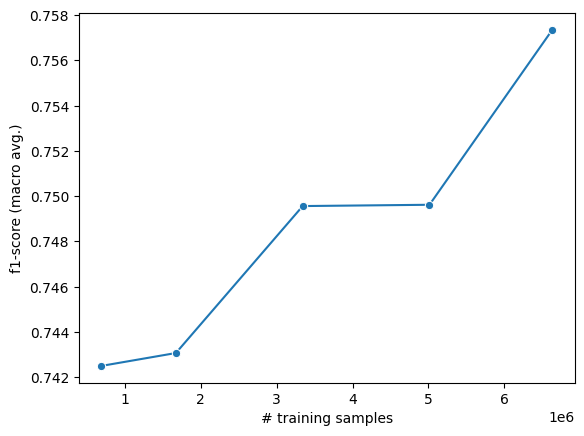

In [8]:
ax = sns.lineplot(
    x='# training samples',
    y='f1-score (macro avg.)',
    marker='o',
    data=pd.DataFrame({
        '# training samples' : train_size,
        'f1-score (macro avg.)': f1_score
    })
);